In [48]:
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
import torch
import umap
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available on this device")
else:
    device = torch.device("cpu")
    print("MPS is not available, using CPU")


dataset = load_dataset("SALT-NLP/silent_signals")
print(dataset)

dataset = dataset["train"]
# as pandas dataframe

df = pd.DataFrame(dataset)


MPS is available on this device
DatasetDict({
    train: Dataset({
        features: ['dog_whistle', 'dog_whistle_root', 'ingroup', 'content', 'date', 'speaker', 'chamber', 'subreddit', 'source', 'definition', 'type', 'party'],
        num_rows: 16258
    })
})


In [49]:
# function that drops duplicates but saves those dropped instances in a separate data frame
def drop_duplicates_save(df):
    duplicates = df[df.duplicated(subset=["content"], keep=False)]
    df = df.drop_duplicates(subset=["content"])
    # drop missing values in lable and content
    df = df.dropna(subset=["content"])
    if "lable" in df.columns:
        df = df.dropna(subset=["lable"])
    return df, duplicates


In [50]:
# filter out the informal and formal sentences
df_informal = df[df["type"] == "Informal"]
df_formal = df[df["type"] == "Formal"]
print('With duplicates:', df_informal.shape, df_formal.shape)
# drop duplicates
df_informal, duplicates_if_1 = drop_duplicates_save(df_informal)
df_formal, duplicates_f_1 = drop_duplicates_save(df_formal)
print('Without duplicates:', df_informal.shape, df_formal.shape)

With duplicates: (12923, 12) (3335, 12)
Without duplicates: (12901, 12) (3298, 12)


In [51]:
# load csv 
null_dataset_formal = pd.read_csv("0_data/formal_neg_predictions.csv")
null_dataset_informal = pd.read_csv("0_data/informal_neg_predictions.csv")

In [52]:
print('With duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)
# drop duplicates
null_dataset_informal, duplicates_if_0 = drop_duplicates_save(null_dataset_informal)
null_dataset_formal, duplicates_f_0 = drop_duplicates_save(null_dataset_formal)
print('Without duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)

With duplicates: (33563, 16) (34360, 14)
Without duplicates: (33057, 16) (34212, 14)


In [53]:
# merge informal and formal datasets
null_dataset = pd.concat([null_dataset_formal, null_dataset_informal])

In [54]:
# EDA
print(null_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 67269 entries, 0 to 34359
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dog_whistle       67269 non-null  object 
 1   dog_whistle_root  67269 non-null  object 
 2   ingroup           67269 non-null  object 
 3   content           67269 non-null  object 
 4   date              67269 non-null  object 
 5   speaker           33045 non-null  object 
 6   chamber           33057 non-null  object 
 7   community         16 non-null     object 
 8   speech_id         26072 non-null  float64
 9   party             29590 non-null  object 
 10  speaker_bioguide  28 non-null     object 
 11  definition        67269 non-null  object 
 12  source            67091 non-null  object 
 13  in_group          40975 non-null  object 
 14  type              67269 non-null  object 
 15  lable             67269 non-null  float64
 16  subreddit         34196 non-null  object 
dty

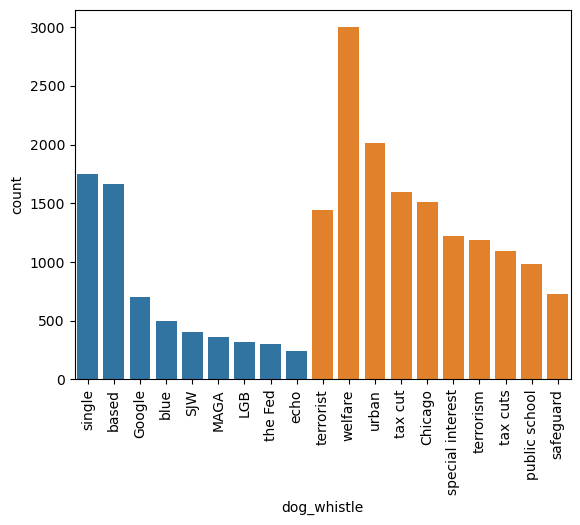

In [55]:
# count plot of informal dog_whistle and formal dog_whistle
import seaborn as sns
# split informal and formal into two bars 
# only the top 10 dog_whistles
sns.countplot(x='dog_whistle', data=null_dataset_informal, order=null_dataset_informal['dog_whistle'].value_counts().iloc[:10].index)
sns.countplot(x='dog_whistle', data=null_dataset_formal, order=null_dataset_formal['dog_whistle'].value_counts().iloc[:10].index)
# rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

In [56]:
# join null informal data and original informal data
df_informal = pd.concat([df_informal, null_dataset_informal])

# label missing values as 1 in label column
df_informal['lable'] = df_informal['lable'].fillna(1)

# join null formal data and original formal data
df_formal = pd.concat([df_formal, null_dataset_formal])

# label missing values as 0 in label column
df_formal['lable'] = df_formal['lable'].fillna(1)

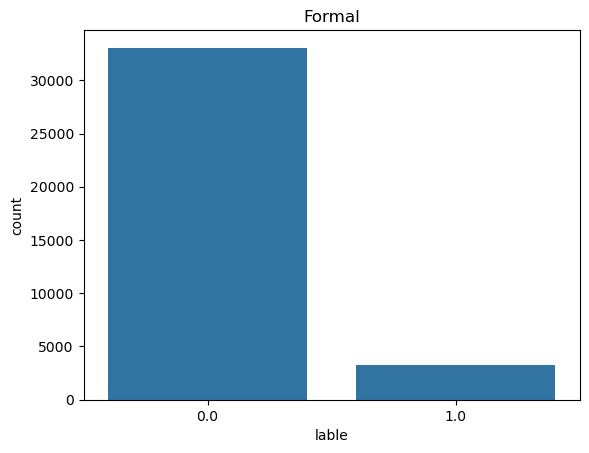

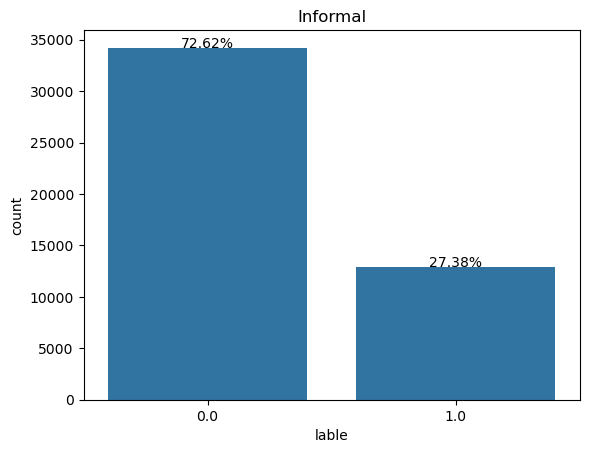

In [99]:
# count plot lable column of informal and formal in one plot 

sns.countplot(x='lable', data=df_formal)
plt.title('Formal')
plt.show()

ax = sns.countplot(x='lable', data=df_informal)
# add percentage of each class
total = len(df_informal)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")

plt.title('Informal')
plt.show()


In [96]:
# describe the data
print(df_informal.describe())

              lable
count  47113.000000
mean       0.273831
std        0.445928
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [58]:
import re
import string
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import random
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, KFold
from cleanlab import Datalab


In [59]:
raw_texts = df_informal['content'].tolist()
labels = df_informal['lable'].tolist()
dog_whistles = df_informal['dog_whistle'].tolist()

In [60]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Configure PyTorch for deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-cased')
model = BertModel.from_pretrained('google-bert/bert-base-cased').to(device)

def get_embeddings_in_batches(texts, batch_size=32):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize the batch of texts
        tokens = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=512
        ).to(device)

        # Generate BERT embeddings
        with torch.no_grad():
            outputs = model(**tokens)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling to get sentence embeddings

        # Move embeddings back to CPU and append to the list
        all_embeddings.append(embeddings.cpu().numpy())

    # Concatenate all embeddings into one numpy array
    return np.concatenate(all_embeddings, axis=0)

# Get embeddings for the dataset
embeddings_np_informal = get_embeddings_in_batches(raw_texts, batch_size=32)

# Define a cross-validation strategy with fixed random state
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Train a classifier using cross-validation
clf = LogisticRegression(max_iter=1000, random_state=seed)
pred_probs = cross_val_predict(
    clf, embeddings_np_informal, labels, method="predict_proba", cv=cv
)

# Use Cleanlab's Datalab to find and report issues
data_dict = {"texts": raw_texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels")
lab.find_issues(pred_probs=pred_probs, features=embeddings_np_informal)
lab.report()


Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 7822 issues found in the dataset.
Dataset Information: num_examples: 47113, num_classes: 2

Here is a summary of various issues found in your data:

    issue_type  num_issues
         label        6514
       outlier        1142
near_duplicate         165
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having l

In [61]:
label_issues = lab.get_issues("label")
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label
0,True,0.031014,1.0,0.0
1,True,0.106208,1.0,0.0
2,True,0.138911,1.0,0.0
3,True,0.038887,1.0,0.0
4,False,0.588963,1.0,1.0


In [62]:
identified_label_issues = label_issues[label_issues["is_label_issue"] == True]


In [101]:
data_with_suggested_labels = pd.DataFrame(
    {"dog_whistles": dog_whistles, "text": raw_texts, "given_label": labels, "suggested_label": label_issues["predicted_label"], "problem": identified_label_issues["is_label_issue"], "label_score": identified_label_issues["label_score"]}
)
potential_wrong_label = data_with_suggested_labels.dropna(subset=["problem"]).sort_values(by="label_score", ascending=False)

In [64]:
# save the potential wrong labels to a csv file
potential_wrong_label.to_csv("vetting_instances/potential_wrong_label_new.csv")

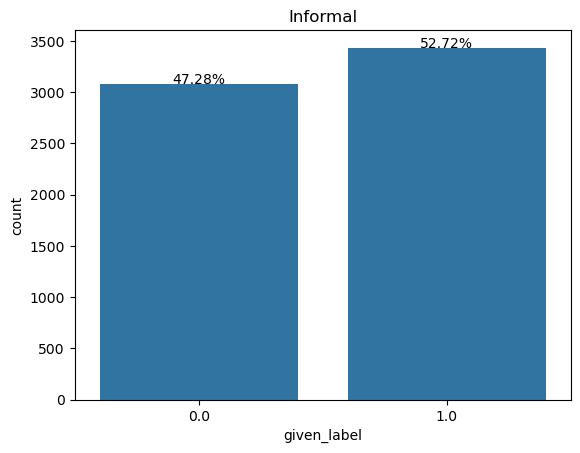

In [103]:
ax = sns.countplot(x='given_label', data=potential_wrong_label)
# add percentage of each class
total = len(potential_wrong_label)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")
plt.title('Informal')
plt.show()

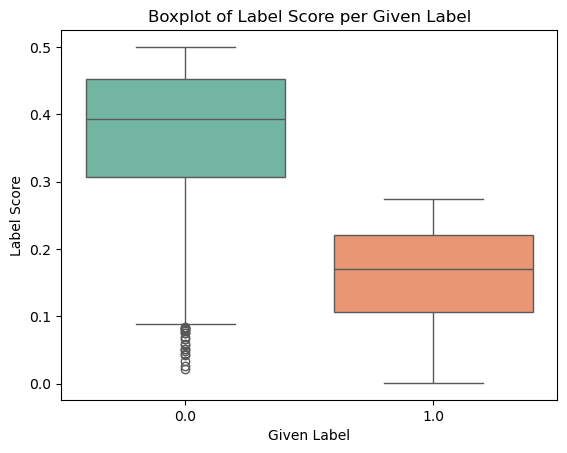

In [108]:
# boxplot of label score per given label
sns.boxplot(x='given_label', y='label_score', data=potential_wrong_label, palette='Set2')
plt.title('Boxplot of Label Score per Given Label')
# x-axis label
plt.xlabel('Given Label')
# y-axis label
plt.ylabel('Label Score')
plt.savefig('boxplot_label_score_per_given_label.png')
plt.show()

In [66]:
# load reviewed_labels.csv
reviewed_labels = pd.read_csv('vetting_instances/reviewed_labels.csv')

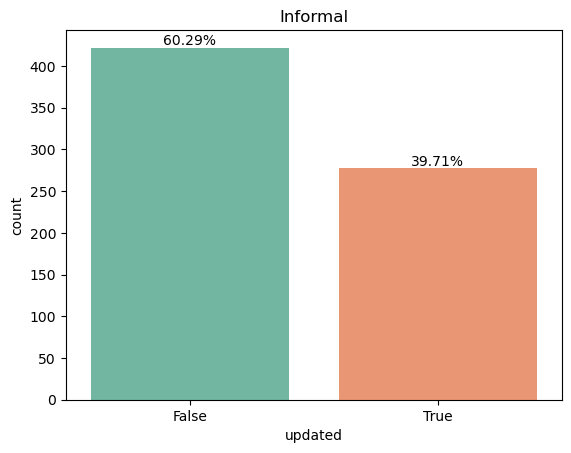

In [90]:
# Count given_label not equal to final_label in reviewed_labels and plot it
reviewed_labels['updated'] = reviewed_labels['given_label'] != reviewed_labels['final_label']
ax = sns.countplot(x='updated', data=reviewed_labels, palette='Set2')
# add percentage to the plot
total = len(reviewed_labels)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")
plt.title('Informal')
plt.show()


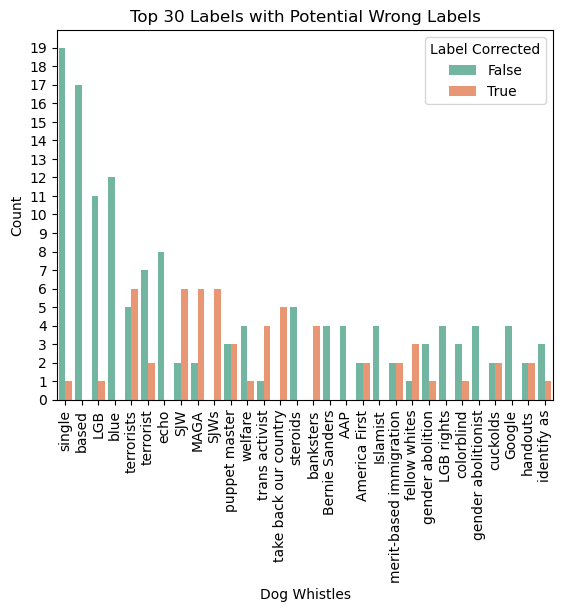

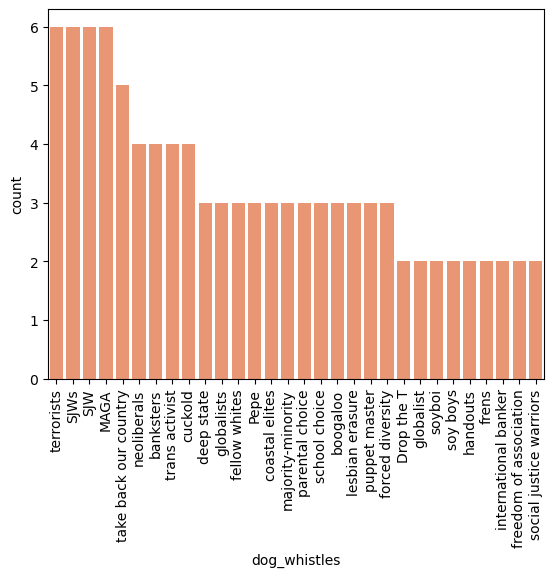

In [114]:

# get the split by updated column
sns.countplot(x='dog_whistles', data=reviewed_labels, hue='updated', order=reviewed_labels['dog_whistles'].value_counts().iloc[:30].index, palette='Set2')
# rotate x-axis labels
plt.xticks(rotation=90)
# y axis ticks only integers
plt.yticks(np.arange(0, 20, 1))
plt.xlabel('Dog Whistles')
# y axis label
plt.ylabel('Count')
# set legend title
plt.legend(title='Label Corrected')
plt.title('Top 30 Labels with Potential Wrong Labels')
# save the plot so it does not get cut off
plt.savefig('top_20_labels_with_potential_wrong_labels.png', bbox_inches='tight')
plt.show()

# most updated dog_whistles in reviewed_labels
updated_dog_whistles = reviewed_labels[reviewed_labels['updated'] == True]
sns.countplot(x='dog_whistles', data=updated_dog_whistles, order=updated_dog_whistles['dog_whistles'].value_counts().iloc[:30].index, color='#fc8d62')
# rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

In [69]:
potential_wrong_label = pd.read_csv('vetting_instances/potential_wrong_label.csv')

In [70]:
# drop all the rows in potential_wrong_label that are in reviewed_labels
potential_wrong_label = potential_wrong_label[~potential_wrong_label['text'].isin(reviewed_labels['text'])]

In [71]:
# Merge the reviewed_labels with the informal dataset
df_informal_reviewed = df_informal.merge(
    reviewed_labels.rename(columns={'text': 'content', 'given_label': 'lable'})[['content', 'lable', 'final_label']],
    on='content',
    how='left'
)
df_informal_reviewed['lable_x'] = df_informal_reviewed['final_label'].combine_first(df_informal_reviewed['lable_x'])
df_informal_reviewed = df_informal_reviewed.drop(columns=['lable_y', 'final_label'])
df_informal_reviewed = df_informal_reviewed.rename(columns={'lable_x': 'lable'})

len(df_informal_reviewed)

47113

In [72]:
# drop all rows in df_informal_reviewed still in potential_wrong_label 
df_informal_reviewed = df_informal_reviewed[~df_informal_reviewed['content'].isin(potential_wrong_label['text'])]
len(df_informal_reviewed)

41297

In [ ]:
# run logistic regression with train test split and BERt embeddings
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

raw_texts_updated = df_informal_reviewed['content'].tolist()
labels_updated = df_informal_reviewed['lable'].tolist()

# Get embeddings for the dataset
embeddings_np_informal_updated = get_embeddings_in_batches(raw_texts_updated, batch_size=32)

# Split the data into training and testing sets
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(
    embeddings_np_informal_updated, labels_updated, test_size=0.2, random_state=seed
)

# Train a classifier using cross-validation
clf = LogisticRegression(max_iter=1000, random_state=seed)
clf.fit(X_train_updated, y_train_updated)
y_pred_updated = clf.predict(X_test_updated)
balanced_accuracy_score(y_test_updated, y_pred_updated)

0.8328839800995025

In [84]:
# f1 score
from sklearn.metrics import f1_score
print('F1 score:',f1_score(y_test_updated, y_pred_updated))
# recall
from sklearn.metrics import recall_score
print('Recall score:',recall_score(y_test_updated, y_pred_updated))

F1 score: 0.7634152788791964
Recall score: 0.718407960199005


In [75]:
# Model with original Dataset

raw_texts = df_informal['content'].tolist()
labels = df_informal['lable'].tolist()

# Get embeddings for the dataset
embeddings_np_informal = get_embeddings_in_batches(raw_texts, batch_size=32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_np_informal, labels, test_size=0.2, random_state=seed
)

# Train a classifier using cross-validation
clf = LogisticRegression(max_iter=1000, random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6695317944117365

In [81]:
# f1 score
print('F1 score:',f1_score(y_test, y_pred))
print('Recall score:',recall_score(y_test, y_pred))

F1 score: 0.5145228215767634
Recall score: 0.4340723453908985


In [88]:
print(sns.color_palette("Set2").as_hex())

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


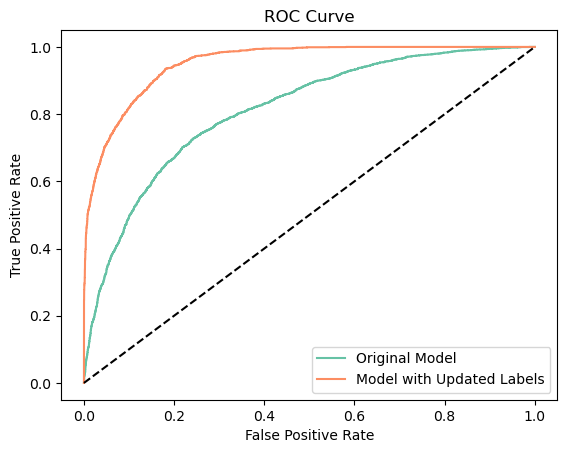

In [115]:
# AUC ROC curve for both models
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
fpr_updated, tpr_updated, _ = roc_curve(y_test_updated, clf.predict_proba(X_test_updated)[:,1])

plt.plot(fpr, tpr, label='Original Model', color='#66c2a5')
plt.plot(fpr_updated, tpr_updated, label='Model with Updated Labels', color='#fc8d62')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

In [113]:
# model results for both models
from sklearn.metrics import classification_report
print('Original Model')
print(classification_report(y_test, y_pred))
print('Model with Updated Labels')
print(classification_report(y_test_updated, y_pred_updated))

Original Model
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85      6852
         1.0       0.63      0.43      0.51      2571

    accuracy                           0.78      9423
   macro avg       0.72      0.67      0.68      9423
weighted avg       0.76      0.78      0.76      9423

Model with Updated Labels
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      6250
         1.0       0.81      0.72      0.76      2010

    accuracy                           0.89      8260
   macro avg       0.86      0.83      0.85      8260
weighted avg       0.89      0.89      0.89      8260

